EDA & Ensemble Model (Top 10 Percentile) 필사 <br>
Source : https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

# 데이터셋 소개
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields
* datetime - hourly date + timestamp  
*season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
*holiday - whether the day is considered a holiday
*workingday - whether the day is neither a weekend nor holiday
*weather<br>
1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
*temp - temperature in Celsius
*atemp - "feels like" temperature in Celsius
*humidity - relative humidity
*windspeed - wind speed
*casual - number of non-registered user rentals initiated
*registered - number of registered user rentals initiated
*count - number of total rentals

# 데이터 요약

In [72]:
# 필요한 라이브러리 불러오기
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [73]:
# 데이터 불러오기
dailyData = pd.read_csv("train.csv")
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [74]:
dailyData.shape

(10886, 12)

In [75]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

# 피쳐엔지니어링

* 범주형 변수 처리 : "season", "holiday", "workingday", "weather"
* 일시 관련 컬럼 생성 : "month", "date", "hour", "weekday"

In [76]:
# 날짜, 시간 구분하기
dailyData["datetime"][1].split()

['2011-01-01', '01:00:00']

In [77]:
# 요일 확인하기
calendar.day_name[pd.to_datetime(dailyData["datetime"][1].split()[0]).weekday()]

'Saturday'

In [78]:
# 월 확인하기
calendar.month_name[pd.to_datetime(dailyData["datetime"][1].split()[0]).month]

'January'

In [79]:
# 계절 데이터 텍스트로 변경
dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })

0        Spring
1        Spring
2        Spring
3        Spring
4        Spring
          ...  
10881    Winter
10882    Winter
10883    Winter
10884    Winter
10885    Winter
Name: season, Length: 10886, dtype: object

In [80]:
# 날씨 데이터 텍스트로 변경
dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", 
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", 
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

0         Clear + Few clouds + Partly cloudy + Partly c...
1         Clear + Few clouds + Partly cloudy + Partly c...
2         Clear + Few clouds + Partly cloudy + Partly c...
3         Clear + Few clouds + Partly cloudy + Partly c...
4         Clear + Few clouds + Partly cloudy + Partly c...
                               ...                        
10881     Clear + Few clouds + Partly cloudy + Partly c...
10882     Clear + Few clouds + Partly cloudy + Partly c...
10883     Clear + Few clouds + Partly cloudy + Partly c...
10884     Clear + Few clouds + Partly cloudy + Partly c...
10885     Clear + Few clouds + Partly cloudy + Partly c...
Name: weather, Length: 10886, dtype: object

In [81]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", 
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [82]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January


In [83]:
# 범주형으로 만들어줄 변수 따로 리스트에 저장하여 범주형 변수화 진행
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [84]:
# 불필요한 컬럼 삭제
dailyData  = dailyData.drop(["datetime"],axis=1)

In [85]:
dailyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  date        10886 non-null  object  
 12  hour        10886 non-null  category
 13  weekday     10886 non-null  category
 14  month       10886 non-null  category
dtypes: category(7), float64(3), int64(4), object(1)
memory usage: 757.1+ KB


In [88]:
# 컬럼 타입 시각화
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"vartype",0:"count"})
dataTypeDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   vartype  9 non-null      object
 1   count    9 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 272.0+ bytes


In [90]:
# variableType 컬럼을 str 형태로 변경
dataTypeDf['variableType'] = dataTypeDf['variableType'].astype(str)
dataTypeDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   vartype  9 non-null      object
 1   count    9 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 272.0+ bytes


In [91]:
# 변수 타입이 몇개씩 존재하는지 확인
dataTypeDf2 = dataTypeDf.groupby('vartype')['count'].sum().to_frame().reset_index().sort_values('count', ascending = False)
dataTypeDf2

,vartype,count
0,category,7
2,int64,4
1,float64,3
3,object,1


<AxesSubplot:xlabel='vartype', ylabel='count'>

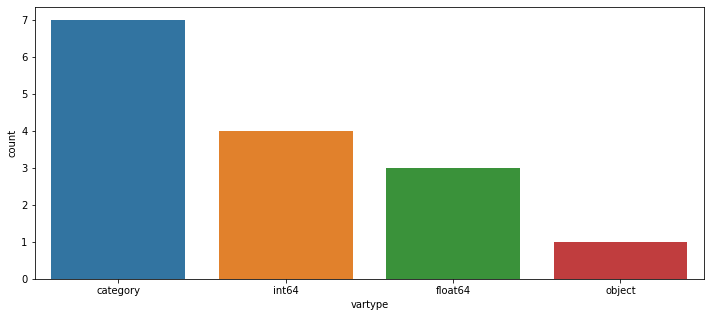

In [92]:
# 그래프로 그리기
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf2, x="vartype", y="count",ax=ax)
#ax.set(xlabel='Variable Type', ylabel='Count',title="Variables DataType Count")

# 결측치 확인

<AxesSubplot:>

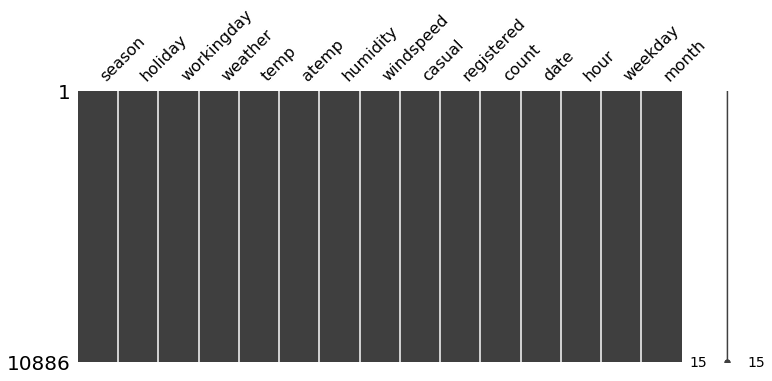

In [37]:
# 결측치 없는 것으로 확인
msno.matrix(dailyData,figsize=(12,5))

# 이상치 확인

In [92]:
# 요일 컬럼 월~일 순서대로 정렬
weekorder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dailyData_weekday['weekday'] = pd.Categorical(dailyData['weekday'], categories = weekorder, ordered = True)
dailyData_weekday = dailyData_weekday.sort_values('weekday')

In [93]:
# 월 컬럼 1월~12월 순서대로 정렬
monthorder = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
dailyData_weekday['month'] = pd.Categorical(dailyData['month'], categories = monthorder, ordered = True)
dailyData_weekday = dailyData_weekday.sort_values('month')

[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Month')]

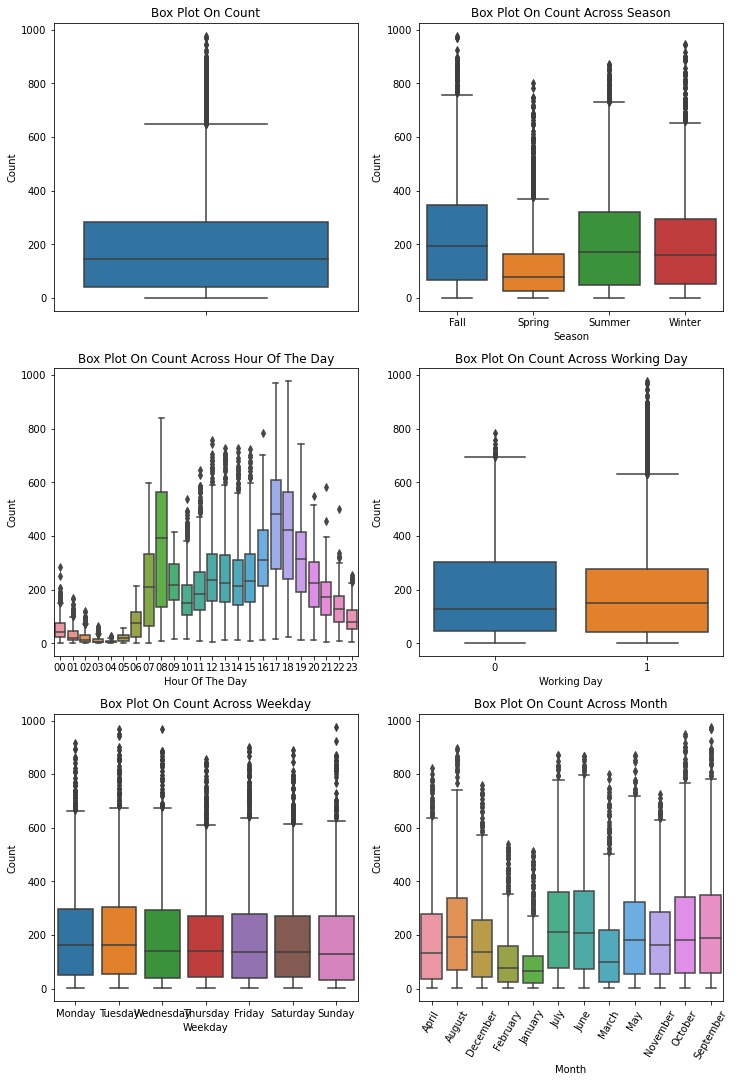

In [94]:
# 전체 데이터, 계절별, 시간별, 근무일/휴일별, 요일별, 월별 이상치 확인
fig, axes = plt.subplots(nrows=3, ncols=2)
plt.xticks(rotation = 60)

fig.set_size_inches(12, 18)
sn.boxplot(data=dailyData, y="count", orient="v", ax=axes[0][0])
sn.boxplot(data=dailyData, y="count", x="season", orient="v", ax=axes[0][1])
sn.boxplot(data=dailyData, y="count", x="hour", orient="v", ax=axes[1][0])
sn.boxplot(data=dailyData, y="count", x="workingday", orient="v", ax=axes[1][1])
sn.boxplot(data=dailyData_weekday, y="count", x="weekday", orient="v", ax=axes[2][0])
sn.boxplot(data=dailyData, y="count", x="month", orient="v", ax=axes[2][1])

axes[0][0].set(ylabel='Count', title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count', title = "Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count', title = "Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count', title = "Box Plot On Count Across Working Day")
axes[2][0].set(xlabel='Weekday', ylabel='Count', title = "Box Plot On Count Across Weekday")
axes[2][1].set(xlabel='Month', ylabel='Count', title = "Box Plot On Count Across Month")

In [87]:
3*dailyData["count"].std()

543.4333614908548

In [154]:
# 이상치 있는 데이터 제외
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 
print ("Shape Of The Before Ouliers: ", dailyData.shape)
print ("Shape Of The After Ouliers: ", dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


# 상관계수 확인

In [55]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
corrMatt

,temp,atemp,casual,registered,humidity,windspeed,count
temp,1.000000,0.984948,0.467097,0.318571,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,0.462067,0.314635,-0.043536,-0.057473,0.389784
casual,0.467097,0.462067,1.000000,0.497250,-0.348187,0.092276,0.690414
registered,0.318571,0.314635,0.497250,1.000000,-0.265458,0.091052,0.970948
humidity,-0.064949,-0.043536,-0.348187,-0.265458,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,0.092276,0.091052,-0.318607,1.000000,0.101369
count,0.394454,0.389784,0.690414,0.970948,-0.317371,0.101369,1.000000


In [60]:
np.tril_indices?
# (n, m) array의 아래쪽 삼각형을 리턴하는 함수

<AxesSubplot:>

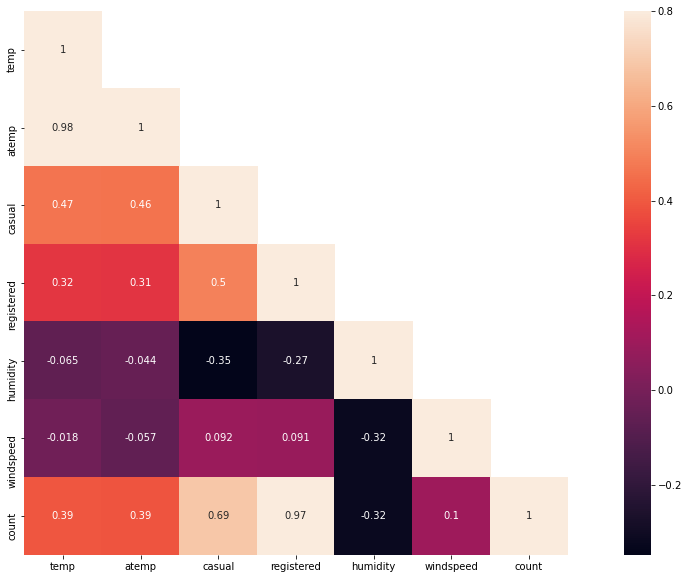

In [64]:
# 연속형 변수간의 상관계수 확인하기
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True)

<AxesSubplot:xlabel='humidity', ylabel='count'>

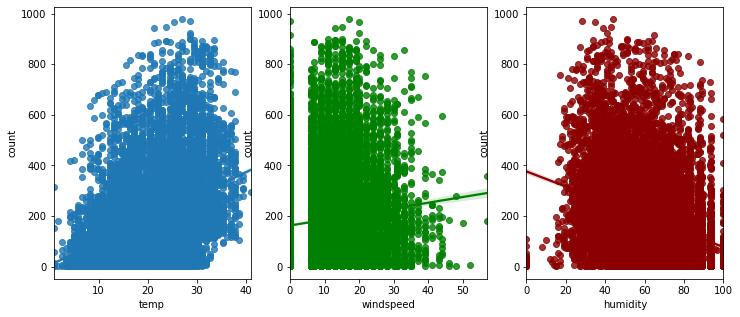

In [91]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData, ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData, ax=ax2, color = "green")
sn.regplot(x="humidity", y="count", data=dailyData, ax=ax3, color = "darkred")

# 데이터 분포 시각화

C:\Users\Chanseo Park\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Chanseo Park\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229774, 4.562423868087808, 0.9581176780909615))

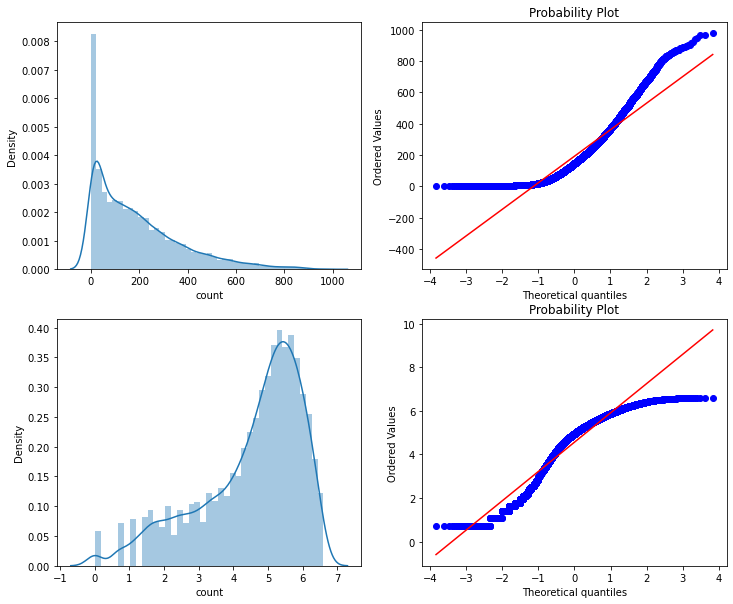

In [157]:
# 이상치처리 전과 후 비교해서 보기
# count 분포가 skewed to right의 형태를 띔
# 머신러닝을 위해 outlier 제거 후 log를 씌워 정규화

fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

# 데이터 컬럼별 시각화

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

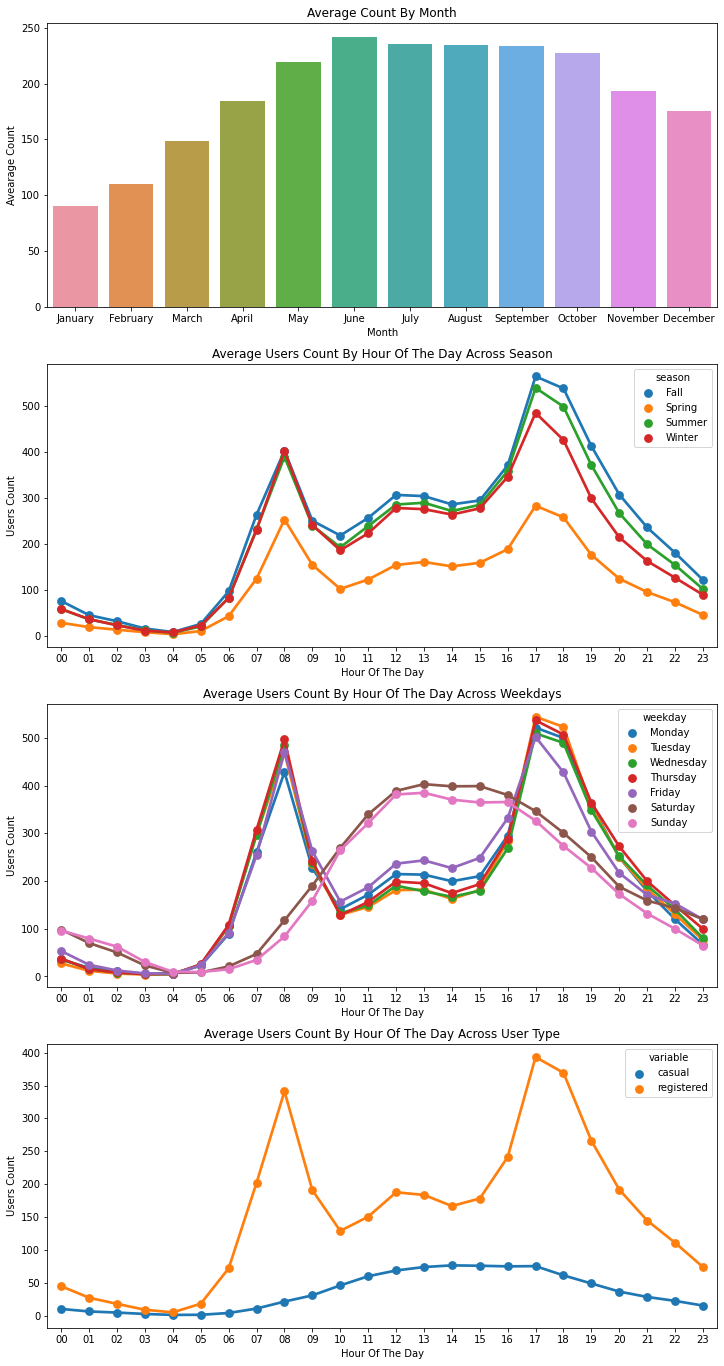

In [102]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,24)

# 6~8월에 해당하는 여름철 자전거 이용량이 가장 높음
monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
sn.barplot(data=monthAggregated,x="month", y="count", ax=ax1, order=monthorder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

# 출퇴근 시간인 8시대, 17시대에 이용량이 가장 높음
hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"], hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Season", label='big')

# 주말에는 출퇴근 시간이 아닌 10~14시대 이용량이 가장 높음
hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=weekorder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

# 출퇴근 시간의 경우 registered 사용자의 이용이 월등히 높음
hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"], sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across User Type", label='big')